In [1]:
# 必要なライブラリーのインポート
from math import factorial
import random

import matplotlib.pyplot as plt
%matplotlib inline
import numpy
import pymop.factory

from deap import algorithms
from deap import base
from deap.benchmarks.tools import igd
from deap import creator
from deap import tools

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as Axes3d

In [2]:
# 問題設定
PROBLEM = "dtlz2"
NOBJ = 3
K = 10
NDIM = NOBJ + K - 1
P = 12
H = factorial(NOBJ + P - 1) / (factorial(P) * factorial(NOBJ - 1))
BOUND_LOW, BOUND_UP = 0.0, 1.0
problem = pymop.factory.get_problem(PROBLEM, n_var=NDIM, n_obj=NOBJ)

# アルゴリズムのパラメータ
MU = int(H + (4 - H % 4))
NGEN = 400
CXPB = 1.0
MUTPB = 1.0

# reference point
ref_points = tools.uniform_reference_points(NOBJ, P)

In [3]:
# 適合度を最小化することで最適化されるような適合度クラスの作成
creator.create("FitnessMin", base.Fitness, weights=(-1.0,) * NOBJ)
# 個体クラスIndividualを作成
creator.create("Individual", list, fitness=creator.FitnessMin)

In [4]:
# 遺伝子生成の関数
def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [5]:
# Toolboxの作成
toolbox = base.Toolbox()
# 遺伝子を生成する関数"attr_gene"を登録
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
# 個体を生成する関数”individual"を登録
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
# 個体集団を生成する関数"population"を登録
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# 評価関数"evaluate"を登録
toolbox.register("evaluate", problem.evaluate, return_values_of=["F"])
# 交叉を行う関数"mate"を登録
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=30.0)
# 変異を行う関数"mutate"を登録
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
# 個体選択法"select"を登録
toolbox.register("select", tools.selNSGA3, ref_points=ref_points)

In [6]:
def main(seed=None):
    random.seed(1)

    # 世代ループ中のログに何を出力するかの設定
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean, axis=0)
    stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)

    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"

    # 第一世代の生成
    pop = toolbox.population(n=MU)
    pop_init = pop[:]
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    print(logbook.stream)

    # 最適計算の実行
    for gen in range(1, NGEN):
        # 子母集団生成
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        # 適合度計算
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # 次世代選択
        pop = toolbox.select(pop + offspring, MU)

        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        print(logbook.stream)

    return pop, pop_init, logbook

In [7]:
if __name__ == "__main__":
    pop, pop_init, stats = main()
    pop_fit = numpy.array([ind.fitness.values for ind in pop])

    pf = problem.pareto_front(ref_points)

gen	evals	std                               	min                               	avg                               	max                               
0  	92   	[0.54682646 0.55340214 0.5598378 ]	[0.0044818  0.00114129 0.01218372]	[0.63474368 0.72221834 1.22915722]	[1.88681643 2.10169004 2.23321813]
1  	92   	[0.58626316 0.54892951 0.51216539]	[0.00312355 0.00114129 0.01150491]	[0.70809816 0.76459448 0.96979707]	[1.9472324  1.93549712 1.99185004]
2  	92   	[0.57751342 0.49568772 0.50082819]	[0.00312355 0.00114129 0.00944679]	[0.60885946 0.69240405 0.97182848]	[1.9472324  1.8806649  1.78655237]
3  	92   	[0.55502155 0.46777622 0.4996216 ]	[0.00233841 0.00114129 0.00944679]	[0.5850496  0.63098401 0.93170737]	[1.93593176 1.45387321 1.78655237]
4  	92   	[0.55015163 0.44347783 0.4938936 ]	[0.00051175 0.00039404 0.00797225]	[0.68713687 0.58233334 0.79310441]	[1.93593176 1.45387321 2.02089663]
5  	92   	[0.50661526 0.4549934  0.49658307]	[4.11819763e-04 9.93436655e-05 2.43673330e-03]	[0.64293

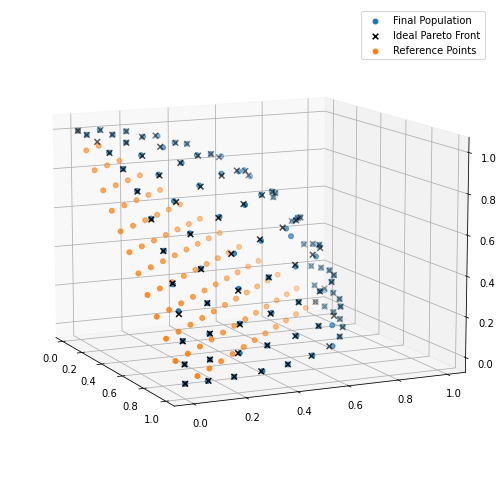

In [8]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

p = numpy.array([ind.fitness.values for ind in pop])
ax.scatter(p[:, 0], p[:, 1], p[:, 2], marker="o", s=24, label="Final Population")

ax.scatter(pf[:, 0], pf[:, 1], pf[:, 2], marker="x", c="k", s=32, label="Ideal Pareto Front")

ref_points = tools.uniform_reference_points(NOBJ, P)

ax.scatter(ref_points[:, 0], ref_points[:, 1], ref_points[:, 2], marker="o", s=24, label="Reference Points")

ax.view_init(elev=11, azim=-25)
ax.autoscale(tight=True)
plt.legend()
plt.tight_layout()